In [2]:
import os
import argparse
import shutil
import pickle
import torch
import sys
import numpy as np
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), './..')))
from src.utils.data import remap, fetch_data_to_write
from tqdm import tqdm
from src.utils.utils import optimal_distance
import cv2
from ultralytics import YOLO

In [3]:
target_labels = {'car', 'bus', 'truck'}

def run_images(img_events, img_rgb, model_events, model_rgb):
    results_events = model_events.track(img_events, persist=True, verbose=False)
    results_rgb = model_rgb.track(img_rgb, persist=True, verbose=False)

    num_of_pred_obj = 0
    for box in results_events[0].boxes:
        confidence = float(box.conf[0])
        class_id = int(box.cls[0])
        # label = model.names[class_id]

        if confidence > conf_thr:
            num_of_pred_obj += 1
            # x1, y1, x2, y2 = map(int, box.xyxy[0])
            # cv2.rectangle(event_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            # cv2.putText(event_frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    pred_obj_in_events.append(num_of_pred_obj)

    num_of_pred_obj_rgb = 0
    for box in results_rgb[0].boxes:
        confidence = float(box.conf[0])
        class_id = int(box.cls[0])
        label = model_rgb.names[class_id]

        if confidence > conf_thr and label in target_labels:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            if np.abs(x1-x2)/1440 < 0.02 or np.abs(y1-y2)/1080 < 0.02:
                continue
            num_of_pred_obj_rgb += 1
    pred_obj_in_rgb.append(num_of_pred_obj_rgb)


In [4]:
recording_names = os.listdir('/mnt/raid0a/Dimitris/DSEC/event_recordings/')
images_prefix = f'../../../E2F/final_res/'
rgb_prefix = '/mnt/raid0a/Dimitris/DSEC/images_recordings/'

model_name = 'e2f_35/x_True_True/weights/epoch8.pt'
conf_thr = 0.35
dataset_type = 'val'
pred_obj = []
gt_obj = []
flagged_sequences = []
for rec_name in recording_names:
    if 'zurich_city_03' in rec_name or 'zurich_city_09' in rec_name or 'zurich_city_10' in rec_name or 'zurich_city_12' in rec_name: # or 'zurich_city_01' in rec_name or 'zurich_city_02' in rec_name:
        continue
    print(rec_name)
    images = os.listdir(images_prefix+rec_name)
    images.sort()
    optimal_distance_val = optimal_distance('DSEC')[0]
    metric = fetch_data_to_write(['partial_contrast'], 'info_DSEC', '',  rec_name)
    metric = metric['partial_contrast']
    distance = np.sum(np.square((metric-optimal_distance_val)), axis=1)
    is_in_test = []
    model_rgb = YOLO('yolo11x')
    model_events = YOLO(model_name)
    pred_obj_in_events = []
    pred_obj_in_rgb = []
    flags = []
    prev = 0
    
    for idx, image in enumerate(images):
        if '.png' not in image:
            continue
        if idx < 5:
            continue

        low = max(0, idx-70)
        high = min(idx+110, len(images))
        is_flagged = distance[idx] > 0.035
        if dataset_type == 'val':
            if (np.max(distance[low:high] > 0.035) and not ('zurich_city_01' in rec_name or 'zurich_city_02' in rec_name or 'zurich_city_06' in rec_name)):
                im1 = cv2.imread(images_prefix+rec_name+'/'+image)
                img = im1
                img_rgb = cv2.imread(rgb_prefix+f'{rec_name}/images/left/rectified/0{image[6:]}')
                if idx == prev+1:
                    flags.append(is_flagged)
                    
                    prev += 1
                elif prev != 0:
                    print(idx)
                    prev = idx
                    flagged_sequences.append(flags)
                    pred_obj.append(pred_obj_in_events)
                    pred_obj_in_events = []
                    gt_obj.append(pred_obj_in_rgb)
                    pred_obj_in_rgb = []
                    flags = [is_flagged]
                else:
                    print(idx)
                    flags.append(is_flagged)
                    prev = idx
                # sdv
                run_images(img, img_rgb, model_events, model_rgb)
            
        if dataset_type == 'hold':
            if (np.max(distance[low:high] < 0.035) and ('zurich_city_06' in rec_name or 'zurich_city_11_a' in rec_name)):
                im1 = cv2.imread(images_prefix+rec_name+'/'+image)
                img = im1
                img_rgb = cv2.imread(rgb_prefix+f'{rec_name}/images/left/rectified/0{image[6:]}')
                run_images(img, img_rgb)

        if dataset_type == 'train':
            if (np.max(distance[low:high] < 0.035) and not ('zurich_city_06' in rec_name or 'zurich_city_11_a' in rec_name)):
                im1 = cv2.imread(images_prefix+rec_name+'/'+image)
                img = im1
                img_rgb = cv2.imread(rgb_prefix+f'{rec_name}/images/left/rectified/0{image[6:]}')
                run_images(img, img_rgb)
    
    if flags != []:
        pred_obj.append(pred_obj_in_events)
        gt_obj.append(pred_obj_in_rgb)
        flagged_sequences.append(flags)
        # print(flagged_sequences, len(flagged_sequences))



zurich_city_01_d
interlaken_00_d
zurich_city_00_b
zurich_city_02_a
zurich_city_04_b
interlaken_00_c
zurich_city_01_a
zurich_city_14_a
zurich_city_00_a
zurich_city_01_e
interlaken_00_f
thun_01_a
zurich_city_02_c
zurich_city_04_d
zurich_city_14_b
zurich_city_06_a
zurich_city_01_b
zurich_city_11_c
zurich_city_15_a
zurich_city_13_b
zurich_city_13_a
zurich_city_02_b
zurich_city_04_a
zurich_city_05_b
zurich_city_08_a
zurich_city_02_e
zurich_city_14_c
zurich_city_04_c
zurich_city_02_d
interlaken_00_g
zurich_city_01_c
zurich_city_05_a
thun_01_b
interlaken_01_a
314
995
1968
zurich_city_04_e
zurich_city_04_f
641
zurich_city_01_f
zurich_city_11_a
interlaken_00_a
interlaken_00_e
interlaken_00_b
447
665
zurich_city_07_a
thun_00_a
zurich_city_11_b


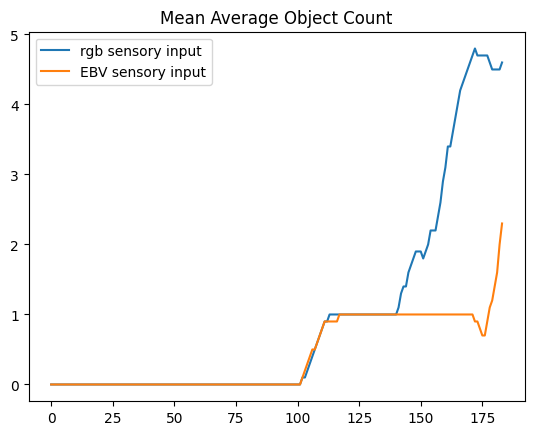

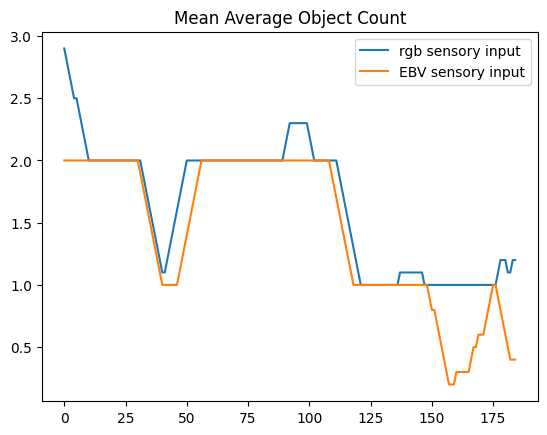

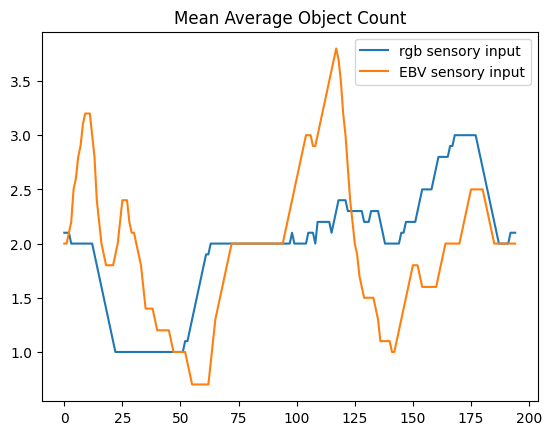

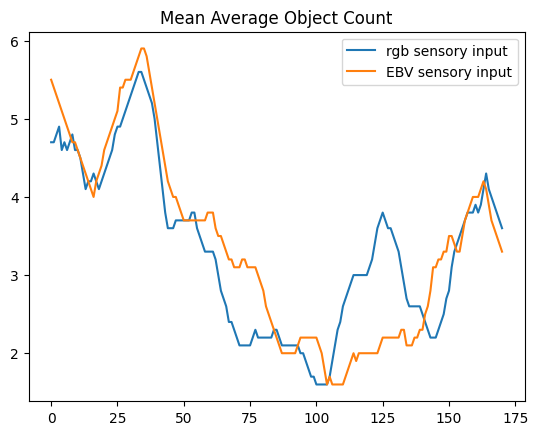

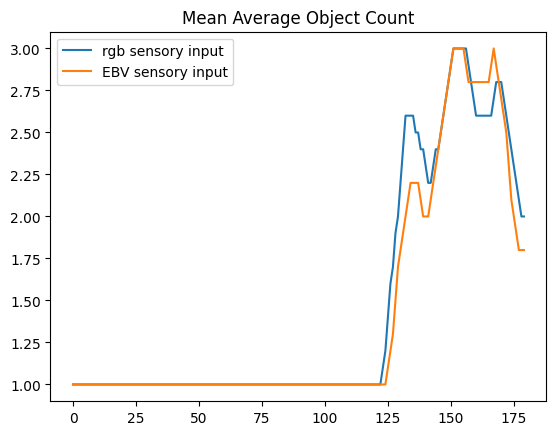

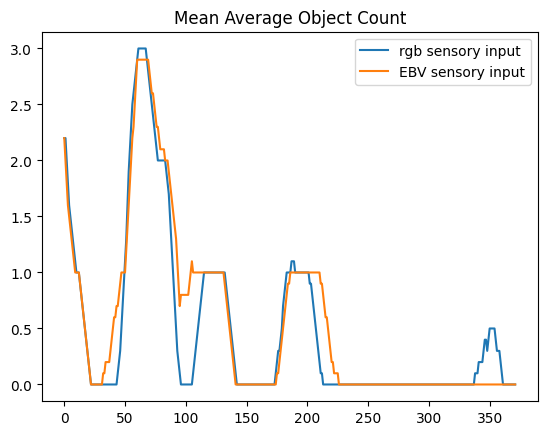

In [5]:
import matplotlib.pyplot as plt
window_size = 10
for i, flagged in enumerate(pred_obj):
    plt.figure()
    plt.title('Mean Average Object Count')
    plt.plot(np.convolve(gt_obj[i], np.ones(window_size)/window_size, mode='valid'), label='rgb sensory input')
    plt.plot((np.convolve(pred_obj[i], np.ones(window_size)/window_size, mode='valid')), label='EBV sensory input')
    plt.legend()
    # plt.plot(flagged_sequences[i])
    plt.show()
    plt.close()

In [6]:
window_size = 10
not_at = []
at = []
for i, flagged in enumerate(pred_obj):
    if i == 0:
        gl_seq = [(75, 125)]
        continue
    elif i == 1:
        continue
    elif i ==2:
        gl_seq = [(2, 125)]
        # continue
    elif i==3:
        gl_seq = [(50, 110), (150, 210)]
    elif i==4:
        gl_seq = [(80, 120), (250, 350), (365, 525)]
    elif i == 5:
        gl_seq = []
    gt_smooth = (np.convolve(gt_obj[i], np.ones(window_size)/window_size, mode='valid'))
    pred_smooth = ((np.convolve(pred_obj[i], np.ones(window_size)/window_size, mode='valid')))
    # print(sum(gt_smooth[0:70])/70-sum(pred_smooth[0:70])/70)
    # print(sum(gt_smooth[70:-70])/(len(pred_smooth)-140)-sum(pred_smooth[70:-70])/(len(pred_smooth)-140))
    # print(sum(gt_smooth[-70:])/70-sum(pred_smooth[-70:])/70)
    prev_min = 0
    for idx, seq in enumerate(gl_seq):
        # gt_smooth_exist = gt_smooth[gt_smooth > 0]
        # pred_smooth_exist = pred_smooth[pred_smooth > 0]
        not_at.append(sum(gt_smooth[prev_min:seq[0]])/(seq[0]-prev_min)-sum(pred_smooth[prev_min:seq[0]])/(seq[0]-prev_min))
        at.append(sum(gt_smooth[seq[0]:seq[1]])/(seq[1]-seq[0])-sum(pred_smooth[seq[0]:seq[1]])/(seq[1]-seq[0]))
        # not_at.append(sum(gt_smooth[prev_min:seq[0]])-sum(pred_smooth[prev_min:seq[0]]))
        # at.append(sum(gt_smooth[seq[0]:seq[1]])-sum(pred_smooth[seq[0]:seq[1]]))
        prev_min = seq[1]
    not_at.append(sum(gt_smooth[seq[1]:])/(len(gt_smooth)-seq[1])-sum(pred_smooth[seq[1]:])/(len(gt_smooth)-seq[1]))
    # not_at.append(sum(gt_smooth[seq[1]:])-sum(pred_smooth[seq[1]:]))
print(at)
print(not_at)


[-0.3398373983739842, -0.31999999999999806, 0.0033333333333329662, 0.0, 0.0, 0.0]
[0.09999999999999987, 0.631428571428571, -0.27000000000000135, 0.6225000000000005, 0.0, 0.0, 0.056153846153846, 0.0, 0.0, 0.0]


In [7]:
print(np.mean(not_at))
print(np.mean(at))


0.1140082417582416
-0.10941734417344155


In [8]:
print(np.std(not_at))
print(np.std(at))


0.27244866550712643
0.15602758154083513


Text(0, 0.5, 'Average object count')

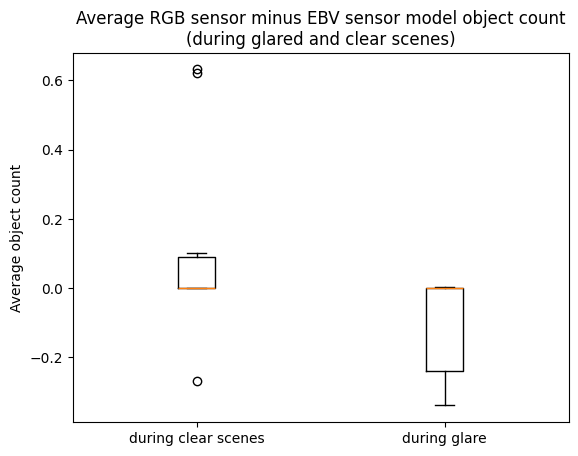

In [9]:
plt.boxplot([not_at, at])
# plt.ylim(-0.5, 0.4)
plt.title('Average RGB sensor minus EBV sensor model object count\n(during glared and clear scenes)')
plt.xticks([1,2],['during clear scenes', 'during glare'])
plt.ylabel('Average object count')

([<matplotlib.axis.XTick at 0x72f26c12b460>,
 [Text(1, 0, 'during clear scenes'), Text(2, 0, 'during glare')])

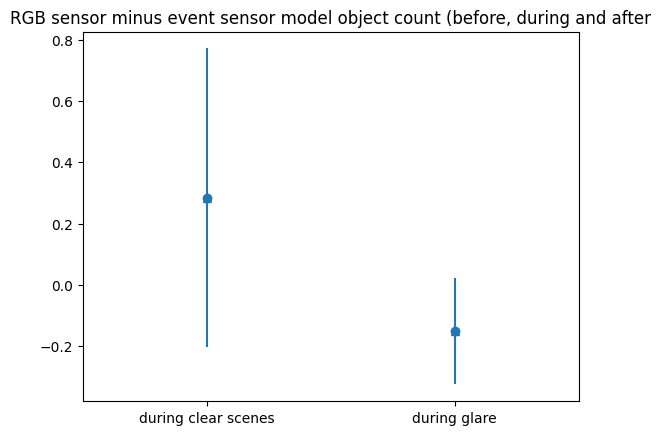

In [127]:
plt.scatter([1,2], [np.mean(not_at), np.mean(at)])
# plt.ylim(-0.4, 0.3)
plt.xlim(0.5, 2.5)
plt.errorbar([1,2], [np.mean(not_at), np.mean(at)], [np.std(not_at), np.std(at)], linestyle='None', marker='^')

plt.title('RGB sensor minus event sensor model object count (before, during and after')
plt.xticks([1,2],['during clear scenes', 'during glare'])

In [ ]:
[maybe (314+75:125), No, No?, 641+50:110 - 641+130:, 447+80:125, 665+40:140, 155:190, 200:315]